In [2]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy.signal import lfilter



In [3]:
plt.rcParams['font.family'] = 'Gill Sans MT'
plt.rcParams["font.size"] = 18

#CONSTANTS -------------------------------
PASCAL_C="#FFFF66"
PASCAL_C2="#FFE599"
PASCAL_C3="#CCCC52"

STSACRA_C= "#D40AA8"
STSACRA_C2="#DB4DBC"
STSACRA_C3= "#FFFFB3"

BEAU_C = "#7771B2"
BEAU_C2 = "#6554FF"
BEAU_C3 = "#A36FBF"

EST_C = "#13BE89"
EST_C2 = "#33FFBE"
EST_C3 = "#0BD65C"

LIMOLI_C = "#12B1BF"
LIMOLI_C2 ="#30EEFF"
LIMOLI_C3 = "#0D828C"

NOEST_C = "#FF9933"
NOEST_C2 = "#FFBF80"
NOEST_C3 = "#806040"


RAIN_C="#5AE3EF"

#UTIL ------------------------------------
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def modifyForPpt(ax):
    
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.tick_params(axis='x',which='both', colors='white')
    ax.tick_params(axis='y',which='both', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    
    return ax

In [4]:
#For PPTs
plt.rcParams["text.color"] = 'white'

In [5]:
def plotTimeSeries(df,dfName,ppt=False,alpha=0.7,colorS=None,limsX=None,limsY=None,points=False):
    
    #For the label
    df.columns = df.copy().columns.str.replace('(m³/h)','')

    #plots the series of each column
    fig1, ax  = plt.subplots(figsize=(14,6)); #creates the figure
        
    if points:
        df.plot(ax= ax,alpha=alpha,marker='.',linewidth=0,color=colorS);
    elif colorS is None:
        df.plot(ax= ax,alpha=alpha);
    else:
        df.plot(ax= ax,alpha=alpha,color=colorS);
        
    #For ppt
    if(ppt):
        ax= modifyForPpt(ax)
    
    #Visual prettiness
    ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(.5,-.18), framealpha=0);#puts the figure in the bottom center with 4 col
    removeTopRightFrame(ax)
    
    ax.set_ylabel("Flow rate (m³/h)")
    
    if limsX is not None:
        ax.set_xlim(limsX)
    if limsY is not None:
        ax.set_ylim(limsY)
    
    fig1.savefig('03-Graphs/'+'Flow'+dfName+'.png', dpi=200, bbox_inches='tight',transparent=True); #saves the fig
    
    return ax

## Process meassurements -----------------------------

In [6]:
#flow meter file
flowDataCsv = '01-Data/01-FlowrateMeassurements.csv'

# create a dataframe with the data from the file 
flowVals = pd.read_csv(flowDataCsv, delimiter = ',',index_col=['Date'])
flowVals.index = pd.to_datetime(flowVals.index, format='%d/%m/%y %H:%M')
#convert string values to numeric replace invalid values as null
flowVals= flowVals.apply(pd.to_numeric, errors='coerce')


In [7]:
#Columns separated by their units
dfFlowsLs=flowVals[['U002 Limoilou Sanitaire (l/s)',
'U002 Limoilou Pluvial (l/s)',
'U016 Beauport Pompe 1 (l/s)',
'U016 Beauport Pompe 2 (l/s)',
'U016 Beauport Pompe 3 (l/s)',
'U225 St-Sacrement Affluent (l/s)',
'U225 St-Sacrement Effluent (l/s)',
'U225 St-Sacrement Entrée réservoir (l/s)',
'U225 St-Sacrement Débordé (l/s)']].copy()

dfFlowsm3h=flowVals[['Station Est (m³/h)',
 'U004 St-Pascal (m³/h)',
 'U003 Nord-Ouest Sanitaire (m³/h)',
 'U003 Nord-Ouest Pluvial (m³/h)',]].copy()

In [8]:
#transformation of the units and renaming the columns
dfFlowsLsTom3h=dfFlowsLs*3.6
dfFlowsLsTom3h.columns = dfFlowsLsTom3h.columns.str.replace('l/s', 'm³/h')
#joining dataframes to create the original complete dataframe
dfFlowsm3h = dfFlowsm3h.join(dfFlowsLsTom3h).copy()

#checks that the join was properly done
assert dfFlowsm3h.shape[0] == flowVals.shape[0]
assert dfFlowsm3h.shape[1] == flowVals.shape[1]

#Cleaning error values
dfFlowsm3h[dfFlowsm3h < 0] = 0 #replace negative values with 0

In [9]:
#Gets statistical distribution and saves it to a csv file
descripFlow=dfFlowsm3h.describe()

descripFlow.to_csv('02-Output/'+'descriptionFlows'+'.csv') 

In [10]:
#separates the flows by place
nordOest = dfFlowsm3h.iloc[:, 2:4].copy()
limoilou = dfFlowsm3h.iloc[:, 4:6].copy()
beauport = dfFlowsm3h.iloc[:, 6:9].copy()
sacrament = dfFlowsm3h.iloc[:, 9:].copy()

# Model data ----------------------------------------------------------

In [11]:
#The values here should be equal to the values from STSACRA_TO_LIMOLIOU + PASCAL_COL
WTP_COL = "DOM_1631424"

STSACRA_TO_LIMOLIOU_COL = "U002_Pompe_IREU" #Pump
PASCAL_COL = "U004" #Pump

NOEST_COL = 'U003_Nord_Ouest' #Pump

#Names created here
STSACRA_TO_LIMOLIOU = "StSacraLimoliou"
PASCAL = "Pascal"
WTP = "WTP"


MOD_SUFFIX = ' (m3/h) MODEL' 

#Names of the measurement file
ESTA_ME = "Station Est (m³/h)"
PASCAL_ME ='U004 St-Pascal (m³/h)'
LIMOILOU_SANI_ME = "U002 Limoilou Sanitaire (m³/h)"
LIMOILOU_PLU_ME = "U002 Limoilou Pluvial (m³/h)"
NO_ME = 'U003 Nord-Ouest Sanitaire (m³/h)'
STSACREMENT_ME = "U225 St-Sacrement Effluent (m³/h)" 



In [12]:

#Not used yet

LIMOILOU_COL = "DOM_941798" #conduit
STSACRA_COL = "UNI_602608" #conduit
BEAU_COL = 'Pompe-Beauport' #Pump


LINKS_MEASS_FLOW = [ LIMOILOU_COL,BEAU_COL,STSACRA_COL,NOEST_COL,PASCAL_COL]



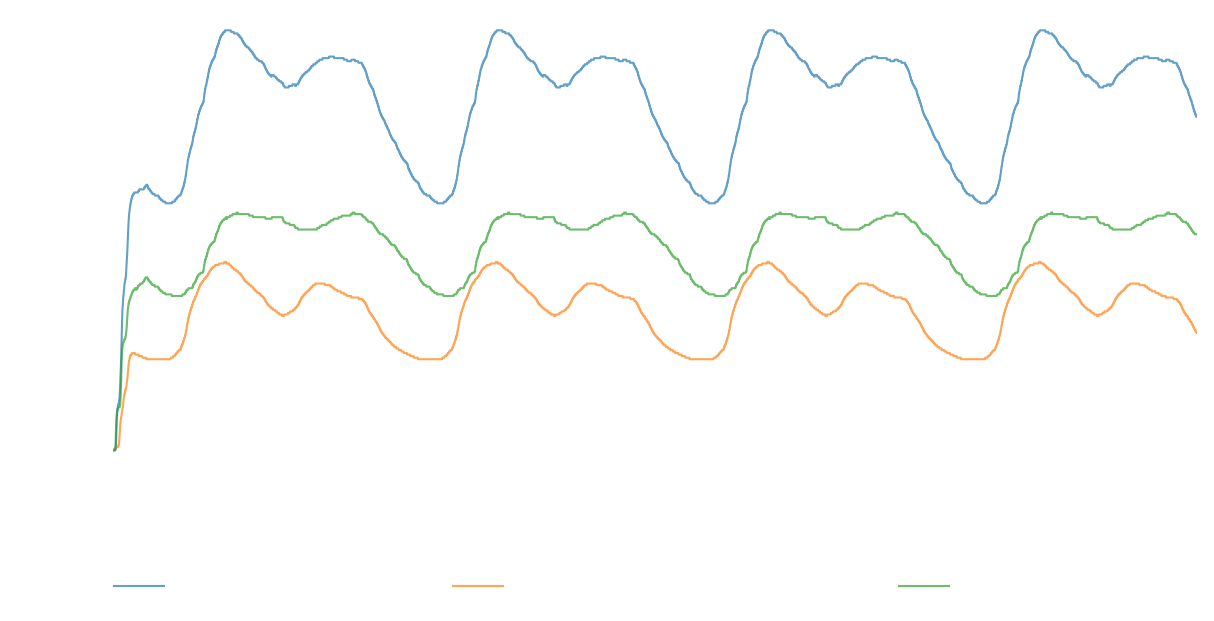

In [15]:
#Check that Limoliou + Pascal give the same data as WTP

flowModel2022Valsm3h["WTP TEST MODEL"] = flowModel2022Valsm3h[STSACRA_TO_LIMOLIOU + MOD_SUFFIX] + flowModel2022Valsm3h[PASCAL+ MOD_SUFFIX]
flowModel2022Valsm3h["WTP DIff"] =  flowModel2022Valsm3h["WTP TEST MODEL"] - flowModel2022Valsm3h[WTP + MOD_SUFFIX]
flowModel2022Valsm3h.describe()


,WTP (m3/h) MODEL,StSacraLimoliou (m3/h) MODEL,Pascal (m3/h) MODEL,WTP TEST MODEL,WTP DIff
count,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000
mean,8085.462381,3256.814596,4829.729974,8086.544570,1.082189
std,1490.987882,777.689827,803.467114,1484.733669,25.299637
min,0.000000,0.000000,0.000000,0.000000,-36.000000
25%,7020.000000,2556.000000,4140.000000,7020.000000,0.000000
50%,8676.000000,3492.000000,5184.000000,8676.000000,0.000000
75%,9108.000000,3852.000000,5436.000000,9108.000000,0.000000
max,9792.000000,4392.000000,5544.000000,9828.000000,396.000000


There are some differences in the test (sum of limoliou and pascal) with the water treatment plant in the mean (small) and the max a bit larger.
YEt in the graph next doesnt show much.

(-40.0, 400.0)

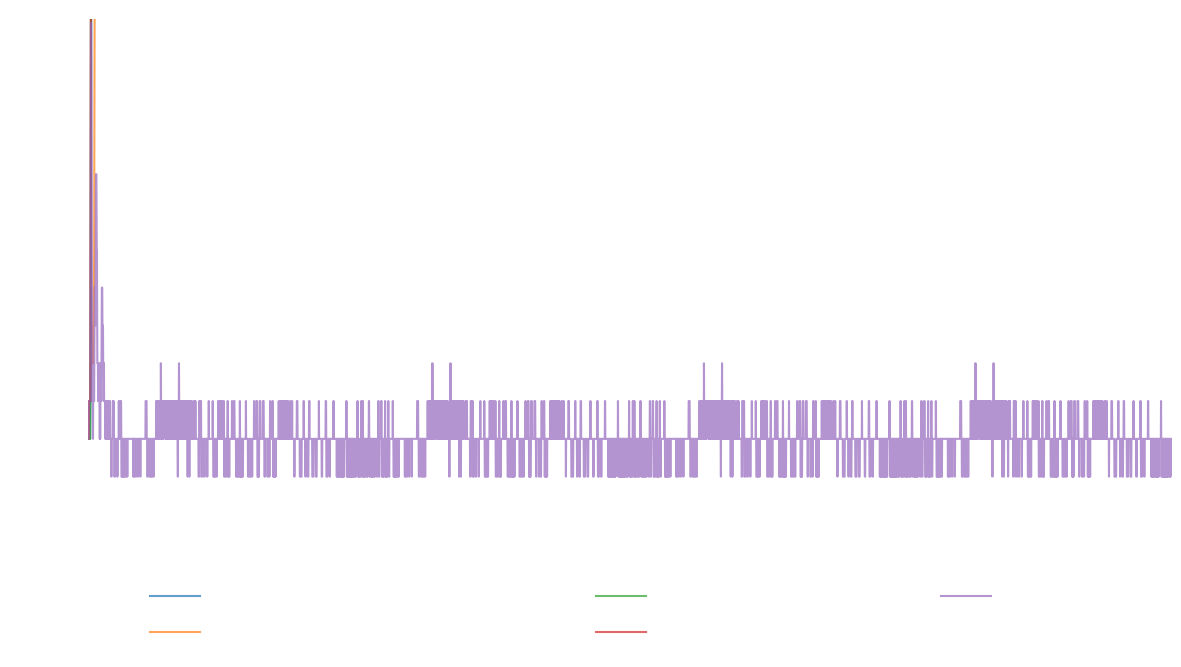

In [16]:
ax = plotTimeSeries(flowModel2022Valsm3h,"FlowModelVals",True)
ax.set_ylim(-40,400)

Largest errors are at the beggining ...

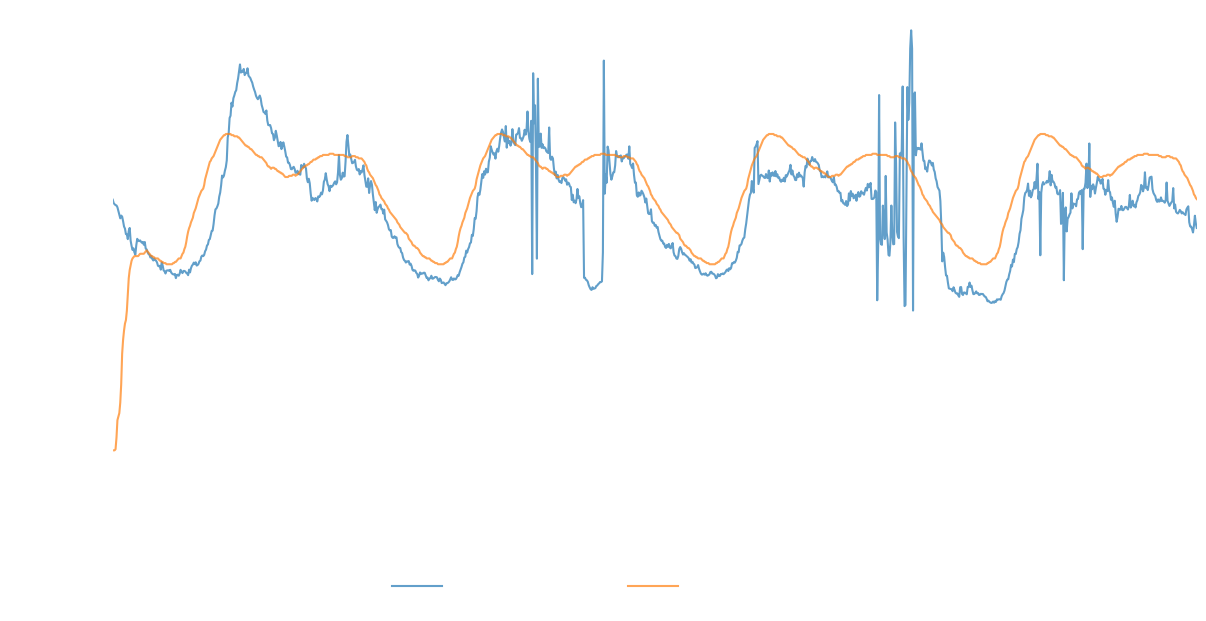

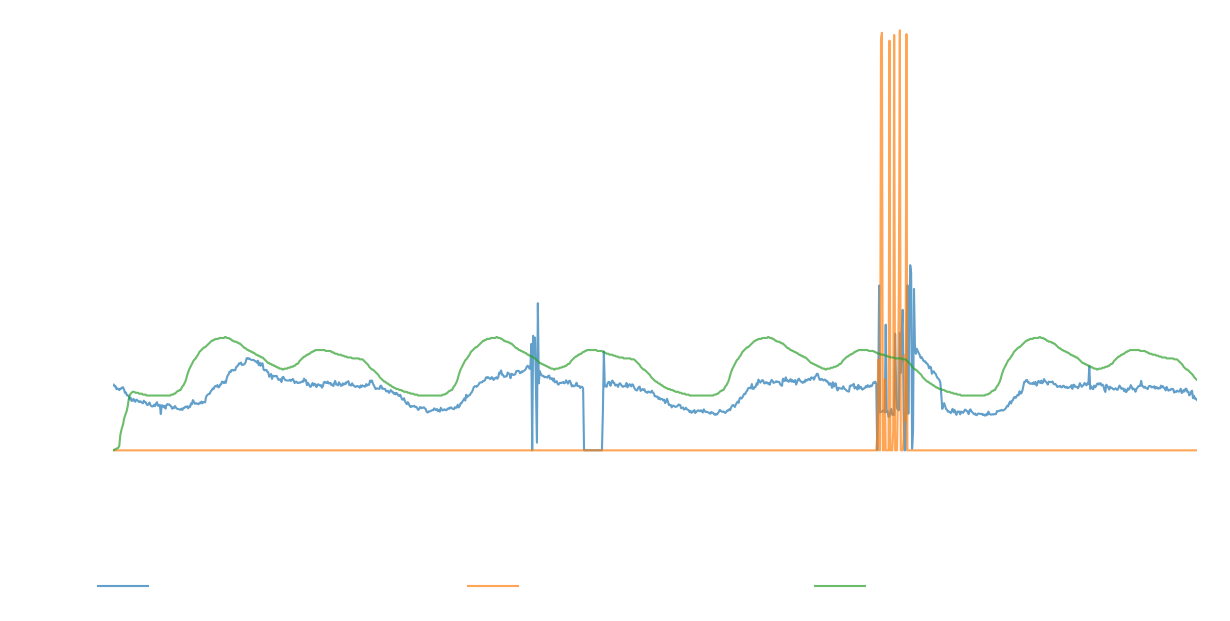

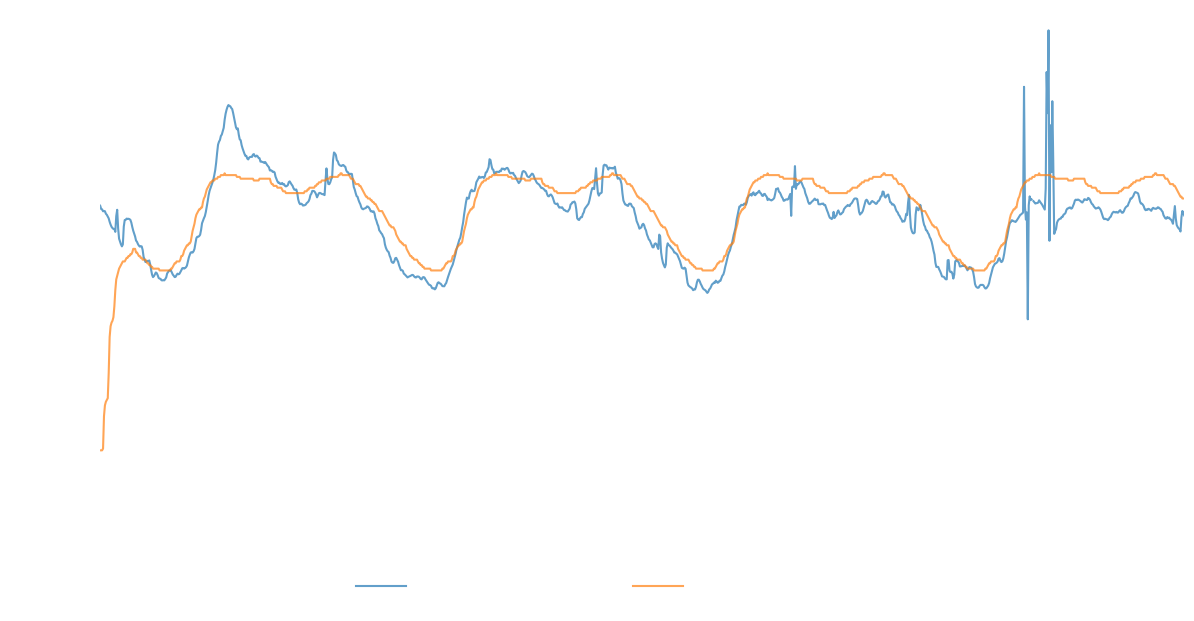

In [16]:
dfFlowsm3hDWF = dfFlowsm3h[(dfFlowsm3h.index >= pd.to_datetime("2022-06-19 00:00:00"))&(dfFlowsm3h.index < pd.to_datetime("2022-06-23 00:00:00"))]


#Combine measured and modelled values to graph them
dfCombinedDWF = dfFlowsm3hDWF.join(flowModel2022Valsm3h)


#Separates the different points
estaEstComb= dfCombinedDWF[[ESTA_ME,WTP + MOD_SUFFIX]]
limoComb=dfCombinedDWF[[LIMOILOU_SANI_ME,LIMOILOU_PLU_ME,STSACRA_TO_LIMOLIOU + MOD_SUFFIX]]
pascalComb= dfCombinedDWF[[PASCAL_ME,PASCAL + MOD_SUFFIX]]

#sacreComb= dfCombinedDWF[["U225 St-Sacrement Effluent (m³/h)","U225 St-Sacrement Entrée réservoir (m³/h)","U225 St-Sacrement Affluent (m³/h)","U225_St_Sacrement  MODEL"]]
#NOestComb= dfCombinedDWF[["U003 Nord-Ouest Sanitaire (m³/h)","U003 Nord-Ouest Pluvial (m³/h)","U003_Nord_Ouest  MODEL"]]


ax = plotTimeSeries(estaEstComb,"ESTComparison",True)
ax1 = plotTimeSeries(limoComb,"LimoComparison",True)
ax2 = plotTimeSeries(pascalComb,"PascalComparison",True)


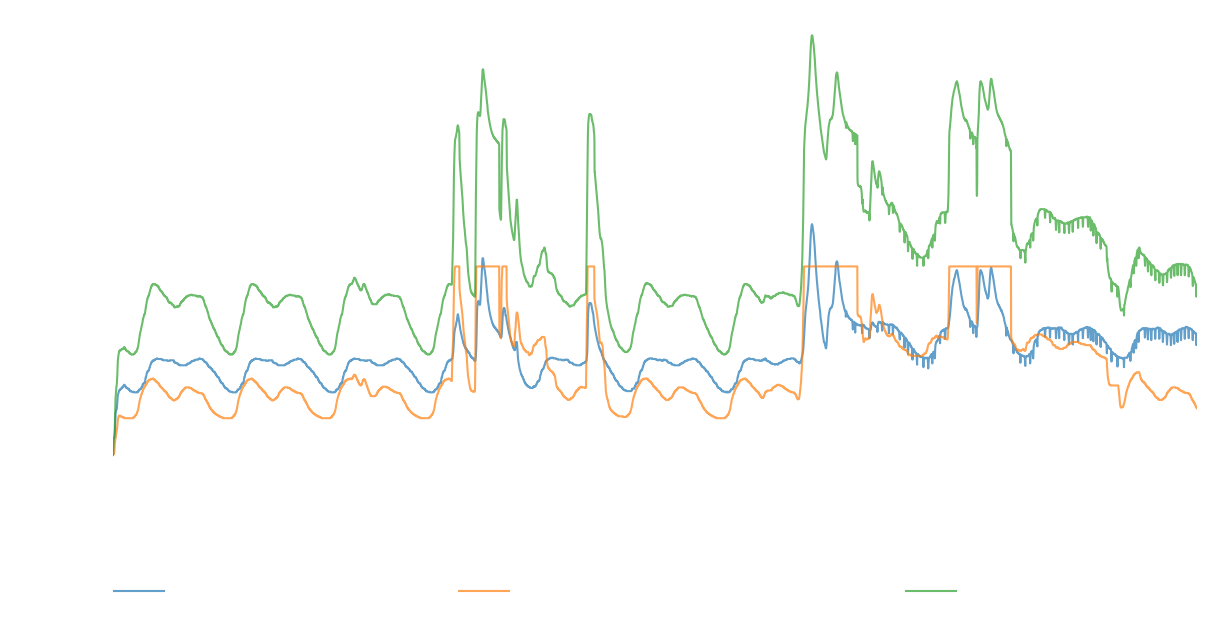

In [29]:
#VALUES 2022 ligth rain

# values are in m3/s
flowModelRLDataCsv = '01-Data/08-ModelFlows2020(LightRainVolumneIN).csv'

flowModelLR2022Valsm3h = getModelData(flowModelRLDataCsv)

ax = plotTimeSeries(flowModelLR2022Valsm3h,"FlowModelLRVals",True)

# Rain data ------------------------------------------------------------------


In [17]:
TH_MM = "Total height (mm)"

In [18]:
#Get rain data
rainCsv = '01-Data/04-RainData2023.csv'
rainVals = pd.read_csv(rainCsv, delimiter = ',')
rainVals["LongDate"] = rainVals[";Date"]+" "+rainVals["Time"] #concat date and time columns
rainVals.drop(columns=[';Date', 'Time'],inplace=True) #removes redundant columns
rainVals["LongDate"]= pd.to_datetime(rainVals["LongDate"],format='%m/%d/%Y %H:%M') # formats date
rainVals.set_index("LongDate",inplace=True)
rainVals.rename(columns={"Hauteur totale (mm)": TH_MM},inplace=True)


<Axes: xlabel='LongDate'>

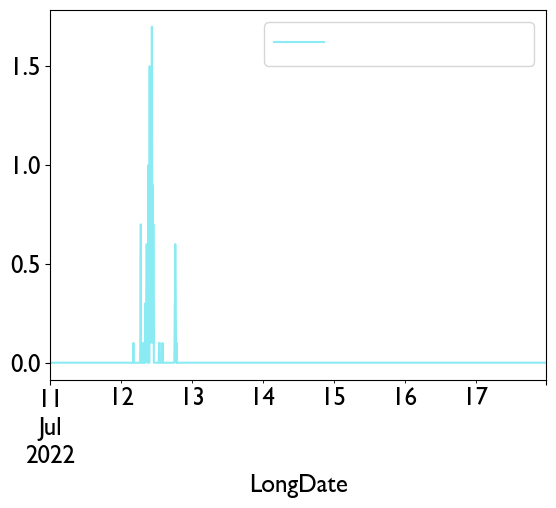

In [19]:
summer = rainVals[(rainVals.index >= pd.to_datetime("2022-07-11 00:00:00"))&(rainVals.index < pd.to_datetime("2022-07-18 00:00:00"))] #.loc["2022-06-15 00:00:00","2022-09-01 00:00:00"]
summer.plot(color=RAIN_C,alpha=0.7)

In [20]:
summer = rainVals[(rainVals.index >= pd.to_datetime("2022-06-19 00:00:00"))&(rainVals.index < pd.to_datetime("2022-06-23 00:00:00"))] #.loc["2022-06-15 00:00:00","2022-09-01 00:00:00"]
DWFCVS = summer.reset_index()

In [21]:
#IMPORTANT!! to this file the header should be manually commented using the ";" at the beggining
def convertRainToSWMMTimeSeriesDat(df,fileName):

    #To be inserted as timeseries in SWMM
    df['Date'] = df["LongDate"].apply(lambda x: x.strftime('%m/%d/%Y'))
    df['Time'] = df["LongDate"].apply(lambda x: x.strftime('%H:%M'))
    df=df.rename(columns={TH_MM: "Value"}).set_index("Date")

    df[["Time","Value"]].to_csv(fileName, sep=' ') 

In [22]:
convertRainToSWMMTimeSeriesDat(DWFCVS,'02-Output/'+'01-DWRain2022'+'.dat')

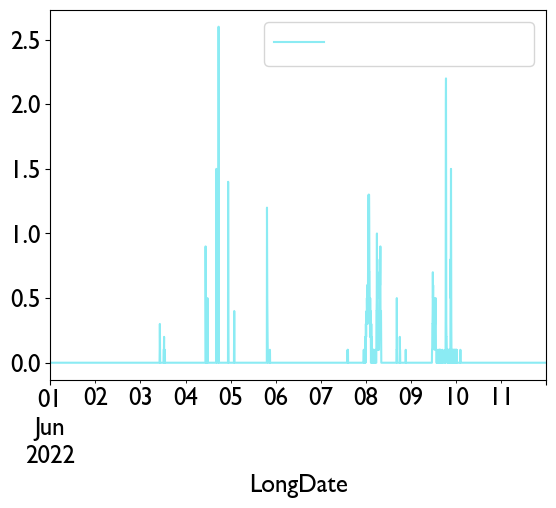

In [27]:
ligthRain = rainVals[(rainVals.index >= pd.to_datetime("2022-06-01 00:00:00"))&(rainVals.index < pd.to_datetime("2022-06-12 00:00:00"))] #.loc["2022-06-15 00:00:00","2022-09-01 00:00:00"]
ligthRain.plot(color=RAIN_C,alpha=0.7)
ligthRainCVS = ligthRain.reset_index()
convertRainToSWMMTimeSeriesDat(ligthRainCVS,'02-Output/'+'02-LigthRain2022'+'.dat')

# WEST DATA ------------------

In [25]:
#Names created here
WTP_WEST = "WTP WEST"
NO_WEST = "NO"
STSACREMENT_WEST = "St-Sacrement"
BEAUPORT = "Beauport"
PASCAL = "Pascal"
LIMOLIOU = "Limoliou"

UNITS_FLOW = ' (m3/d)'
UNITS_GRAPH_FLOW = ' (m3/h)'


#WEST model names
STATION_EST_WEST = ".Qin_GC.Q_In" 
ST_SACREMENT_CATCH_WEST = ".Sew_1.Q_In" 
NO_CATCH_WEST = ".Sew_33.Q_In" #Catchment
STSACRE_B4_LIMOLIOU_WEST = ".Sew_90.Q_Out"  #all before limoilou leg
UPSTREAM_LIMOLIOU_WEST = ".Well_18.Q_Out" # limoilou leg
STSACRE_TO_LIMOLIOU_WEST = ".Well_20.Q_In1" # all incluided limoilou
BEAUPORT_WEST = ".Well_20.Q_In2" # beauport includes all pascal

nameEquivalents = {STATION_EST_WEST: WTP_WEST,
                   NO_CATCH_WEST: NO_WEST,
                  BEAUPORT_WEST: PASCAL,
                  ST_SACREMENT_CATCH_WEST: STSACREMENT_WEST,
                  STSACRE_B4_LIMOLIOU_WEST: "St_sacrement B4 Limoliou",
                  UPSTREAM_LIMOLIOU_WEST: LIMOLIOU,
                  STSACRE_TO_LIMOLIOU_WEST: "St_sacrement to Limoliou"}



In [26]:
startDate = flowModel2022Valsm3h.index[0]
endDate = flowModel2022Valsm3h.index[-1]

In [54]:
#Obtains the data which is in m3/d and convert it to m3/h (IMPOTANT!!!!)
def getDFWESTResults(WEST_WTP_csv,dateIni,dateFin):

    WTP_WEST_Results = pd.read_csv(WEST_WTP_csv, delimiter = ',')

    WTP_WEST_Results['#.t'] = WTP_WEST_Results['#.t']-WTP_WEST_Results['#.t'].min()  #Coz i started the simulation on day 5 
    
    # Convert the "Days" column to timedelta objects (days) and calcualte the date base on the starting date 
    startDatetime = pd.to_datetime(startDate)
    endDatetime = pd.to_datetime(endDate)
    WTP_WEST_Results['#.t'] = pd.to_timedelta(WTP_WEST_Results['#.t'], unit='D')
    WTP_WEST_Results['Date'] = dateIni + WTP_WEST_Results['#.t'] 
    
    WTP_WEST_ResultsCut= WTP_WEST_Results[WTP_WEST_Results['Date']< dateFin]
    WTP_WEST_ResultsCut = WTP_WEST_ResultsCut.drop(columns=['#.t']).set_index('Date')

    # pass from m3/d to m3/h
    for column in WTP_WEST_ResultsCut.columns:

        WTP_WEST_ResultsCut[column] = WTP_WEST_ResultsCut[column] /24
        WTP_WEST_ResultsCut.rename(columns={column:nameEquivalents[column]},inplace=True)

    return WTP_WEST_ResultsCut
    

In [62]:
#WEST_WTP_csv = '01-Data/07-WESTFlowEST.csv'
WEST_WTP_csv = '01-Data/03-ResultsOldWESTModel(DWF)/02-WESTFlowResults.csv'
dfWEST_Results = getDFWESTResults(WEST_WTP_csv,startDate,endDate)


# COmparisons -----

In [112]:
def plotComparisonsMeasSWMMWST(measured, modeled, west, pointName,colors):

    #For the label
    modeled = modeled.copy().rename(columns={modeled.columns[0]:"SWMM"})

    #plots the series of each column
    fig1, ax  = plt.subplots(figsize=(14,6)); #creates the figure

    if (measured is not None):
        measured = measured.copy().rename(columns={measured.columns[0]:"Measured"})
        measured.plot(ax=ax, alpha=0.8, marker='.', linewidth=0, color=colors[0]);
    
    modeled.plot(ax=ax, alpha=0.8, linewidth=2, ls='--', color=colors[1]);

    if (west is not None):
        west = west.copy().rename(columns={west.columns[0]:"WEST"})
        west.plot(ax=ax, alpha=0.8, linewidth=2, color= colors[2]);
    
    ax= modifyForPpt(ax)
        
    ax.set_ylabel("Flow rate (m³/h)")
    
    ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(.45,-.22), framealpha=0);#puts the figure in the bottom center with 4 col
    removeTopRightFrame(ax)

    fig1.savefig('03-Graphs/'+'Comparison'+pointName+'.png', dpi=200, bbox_inches='tight',transparent=True); #saves the fig
   
   


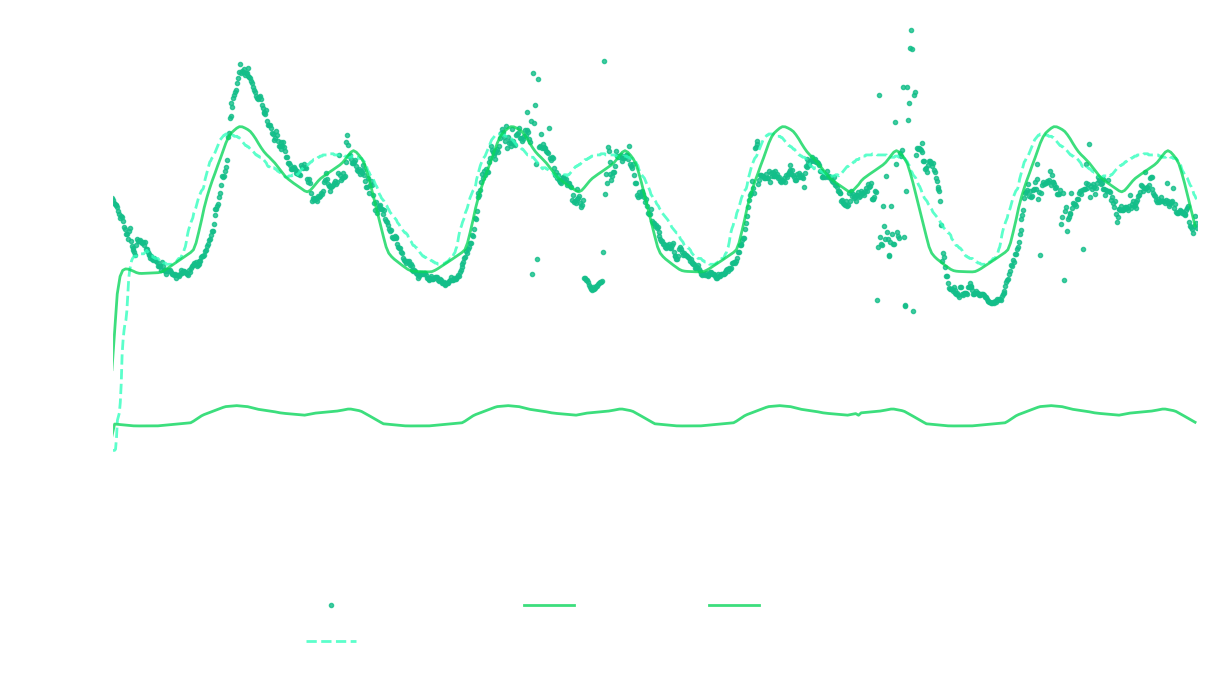

In [41]:
estaEstComb= dfCombinedDWF[[ESTA_ME,WTP + MOD_SUFFIX]]
limoComb=dfCombinedDWF[[LIMOILOU_SANI_ME,LIMOILOU_PLU_ME,STSACRA_TO_LIMOLIOU + MOD_SUFFIX]]
pascalComb= dfCombinedDWF[[PASCAL_ME,PASCAL + MOD_SUFFIX]]
plotComparisonsMeasSWMMWST(estaEstComb[[ESTA_ME]],estaEstComb[[WTP + MOD_SUFFIX]],dfWEST_Results,"StationEST",[EST_C,EST_C2,EST_C3])


In [43]:

plotComparisonsMeasSWMMWST(pascalComb[[PASCAL_ME]],pascalComb[[PASCAL + MOD_SUFFIX]],dfWEST_Results[[BEAUPORT_WEST]],"Pascal",[PASCAL_C,PASCAL_C2,BEAU_C])


KeyError: "None of [Index(['Beauport'], dtype='object')] are in the [columns]"

In [32]:
dfCombinedDWF["Pascal + Limoliou (SWMM)"] = dfCombinedDWF[PASCAL + MOD_SUFFIX] + dfCombinedDWF[STSACRA_TO_LIMOLIOU + MOD_SUFFIX]
dfCombinedDWF["Pascal + Limoliou"] = dfCombinedDWF[PASCAL_ME] + dfCombinedDWF[LIMOILOU_SANI_ME]

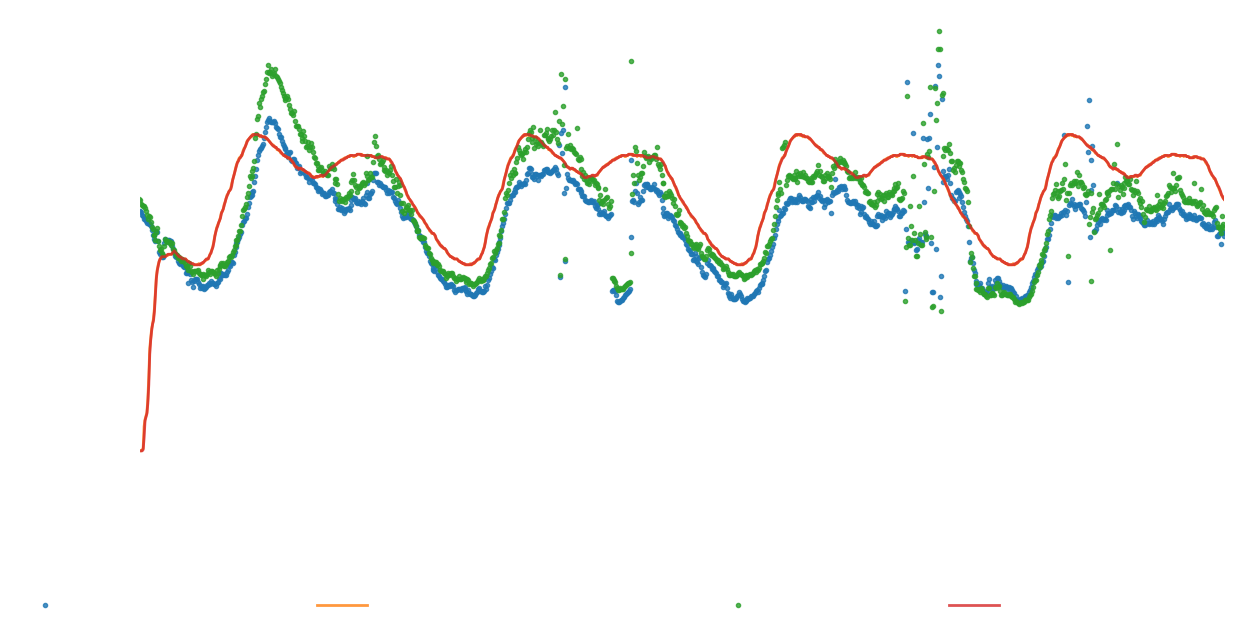

In [33]:

 #plots the series of each column
fig1, ax  = plt.subplots(figsize=(14,6)); #creates the figure
            
dfCombinedDWF[["Pascal + Limoliou"]].plot(ax=ax, alpha=0.8, marker='.', linewidth=0);
    
dfCombinedDWF[["Pascal + Limoliou (SWMM)"]].plot(ax=ax, alpha=0.8, linewidth=2);

dfCombinedDWF[[ESTA_ME]].rename(columns={ESTA_ME: "Station EST"}).plot(ax=ax, alpha=0.8, marker='.', linewidth=0);
dfCombinedDWF[[WTP + MOD_SUFFIX]].rename(columns={WTP + MOD_SUFFIX: "Station EST (SWMM)"}).plot(ax=ax, alpha=0.8, linewidth=2);

    
ax= modifyForPpt(ax)
        
ax.set_ylabel("Flow rate (m³/h)")
    
ax.legend(ncol=4,loc='upper center',bbox_to_anchor=(.45,-.22), framealpha=0);#puts the figure in the bottom center with 4 col
removeTopRightFrame(ax)

fig1.savefig('03-Graphs/'+'ComparisonTOTAL''.png', dpi=200, bbox_inches='tight',transparent=True); #saves the fig
   
   

In [34]:
# values are in m3/s
flowModelDataCsv = '01-Data/06-ModelFlowsDWF2022(Complete).csv'

flowModel2022Valsm3h = getModelData(flowModelDataCsv)

#ax = plotTimeSeries(flowModel2022Valsm3h,"FlowModelVals",True)
flowModel2022Valsm3h = flowModel2022Valsm3h[(flowModel2022Valsm3h.index >= pd.to_datetime("2022-06-19 00:00:00"))&(flowModel2022Valsm3h.index < pd.to_datetime("2022-06-23 00:00:00"))]



In [45]:
# NO

plotComparisonsMeasSWMMWST(dfFlowsm3hDWF[[NO_ME]],flowModel2022Valsm3h[[NOEST_COL + MOD_SUFFIX]],dfWEST_Results[[NO_WEST]],"NO",[NOEST_C,NOEST_C2,NOEST_C3])

KeyError: "None of [Index(['NO'], dtype='object')] are in the [columns]"

In [36]:
# St-Sacrement

STSACRA_COL = "UNI_602608" #Salida tanque st sacra
LEAVETO_BEFORE_STSACRA_COL = "DOM_602606"
PATH_AFTER_STSACRA = "UNI_602607"

plotComparisons(dfFlowsm3hDWF[[STSACREMENT_ME]],flowModel2022Valsm3h[[PATH_AFTER_STSACRA + MOD_SUFFIX]],dfWEST_Results[[STSACREMENT_WEST]],"STSacrement",[STSACRA_C,STSACRA_C2,STSACRA_C3])

NameError: name 'plotComparisons' is not defined

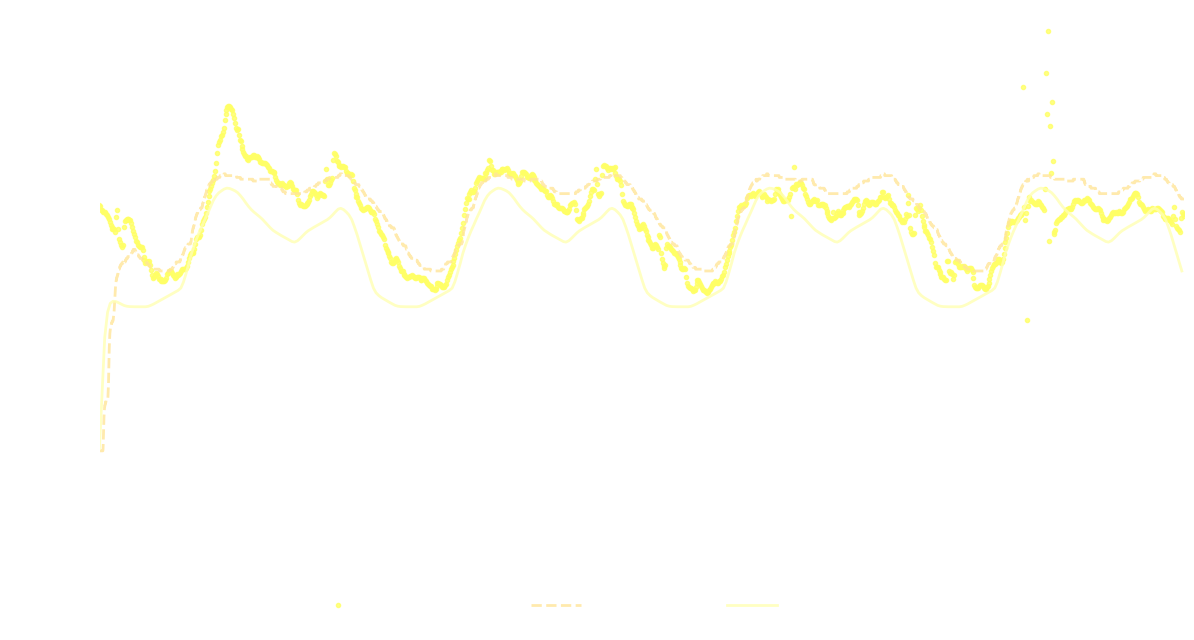

In [74]:
#Beauport

BEAU_COL = 'Pompe-Beauport'
BEAULEG_BEFORE_PASCAL_JOINT= 'C1'

plotComparisonsMeasSWMMWST(pascalComb[[PASCAL_ME]],flowModel2022Valsm3h[[PASCAL + MOD_SUFFIX]],dfWEST_Results[[PASCAL]],"Beauport",[PASCAL_C,PASCAL_C2,PASCAL_C3])

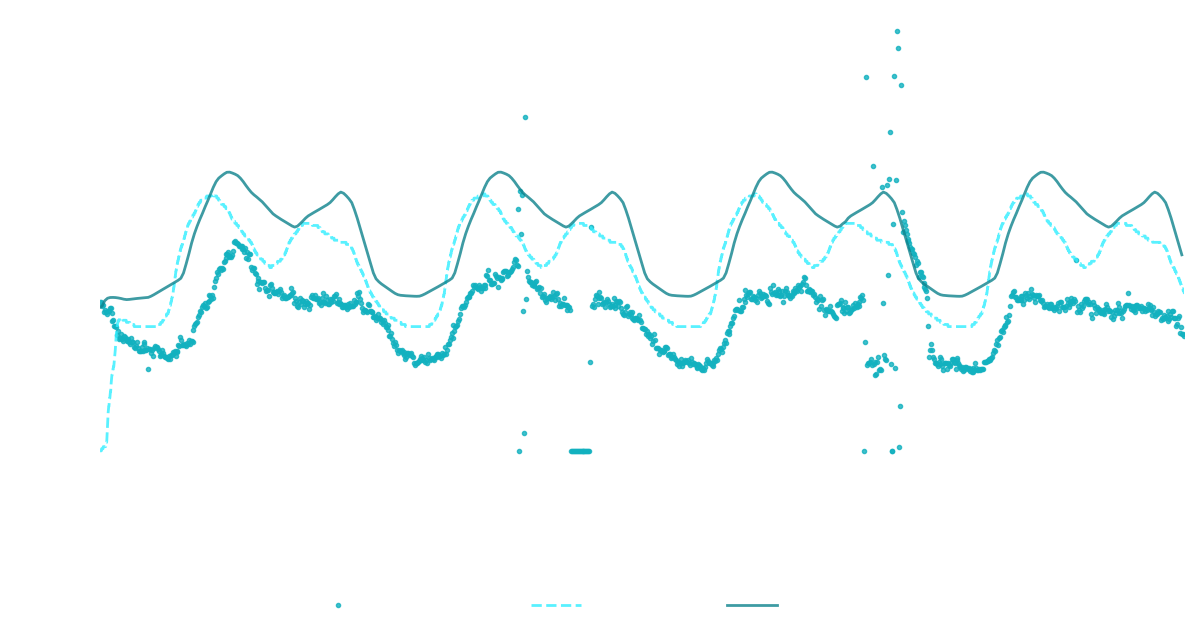

In [84]:
STSACRA_TO_LIMOLIOU_WEST="St_sacrement to Limoliou"	
plotComparisonsMeasSWMMWST(dfFlowsm3hDWF[[LIMOILOU_SANI_ME]],flowModel2022Valsm3h[[STSACRA_TO_LIMOLIOU + MOD_SUFFIX]],dfWEST_Results[[STSACRA_TO_LIMOLIOU_WEST]],"Limoliou",[LIMOLI_C,LIMOLI_C2,LIMOLI_C3])


In [83]:
dfWEST_Results


,WTP WEST,St-Sacrement,NO,St_sacrement B4 Limoliou,Limoliou,St_sacrement to Limoliou,Pascal
Date,,,,,,,
2022-06-19 00:01:00.000000000,2500.800833,156.927767,451.570000,1957.241250,489.920708,2447.161958,53.638858
2022-06-19 00:15:25.088640000,3660.072875,282.780287,814.353583,1910.947042,562.041333,2472.988375,1187.084500
2022-06-19 00:29:48.172800000,4840.858750,280.023875,806.412125,1968.000500,598.008833,2566.009333,2274.849542
2022-06-19 00:44:12.406080000,5382.886667,277.263821,798.460125,2004.347333,604.460458,2608.807833,2774.078917
2022-06-19 00:58:36.760319999,5571.775000,274.503367,790.506958,2022.310792,598.733542,2621.044333,2950.730500
...,...,...,...,...,...,...,...
2022-06-22 22:49:00.596160000,8297.880000,368.040979,1060.777083,3139.471042,838.871208,3978.342208,4319.537917
2022-06-22 23:03:24.665280000,7967.511250,351.491425,1013.073792,3021.177750,803.200083,3824.377833,4143.133250
2022-06-22 23:17:48.665280000,7631.112917,334.943258,965.374500,2900.453625,767.544333,3667.997958,3963.114750


In [90]:
# values are in m3/s
flowModelDataCsvLimo = '01-Data/06-ModelFlowsDWF2022(ONLYLimoilou).csv'

flowModel2022Valsm3hLimo = getModelData(flowModelDataCsvLimo)

#ax = plotTimeSeries(flowModel2022Valsm3h,"FlowModelVals",True)
flowModel2022Valsm3hLimo = flowModel2022Valsm3hLimo[(flowModel2022Valsm3hLimo.index >= pd.to_datetime("2022-06-19 00:00:00"))&(flowModel2022Valsm3hLimo.index < pd.to_datetime("2022-06-23 00:00:00"))]


# values are in m3/s
flowModelDataCsvB4Limo = '01-Data/06-ModelFlowsDWF2022(ONLYB4Limoilou).csv'

flowModel2022Valsm3hB4Limo = getModelData(flowModelDataCsvB4Limo)

#ax = plotTimeSeries(flowModel2022Valsm3h,"FlowModelVals",True)
flowModel2022Valsm3hB4Limo = flowModel2022Valsm3hB4Limo[(flowModel2022Valsm3hB4Limo.index >= pd.to_datetime("2022-06-19 00:00:00"))&(flowModel2022Valsm3hB4Limo.index < pd.to_datetime("2022-06-23 00:00:00"))]



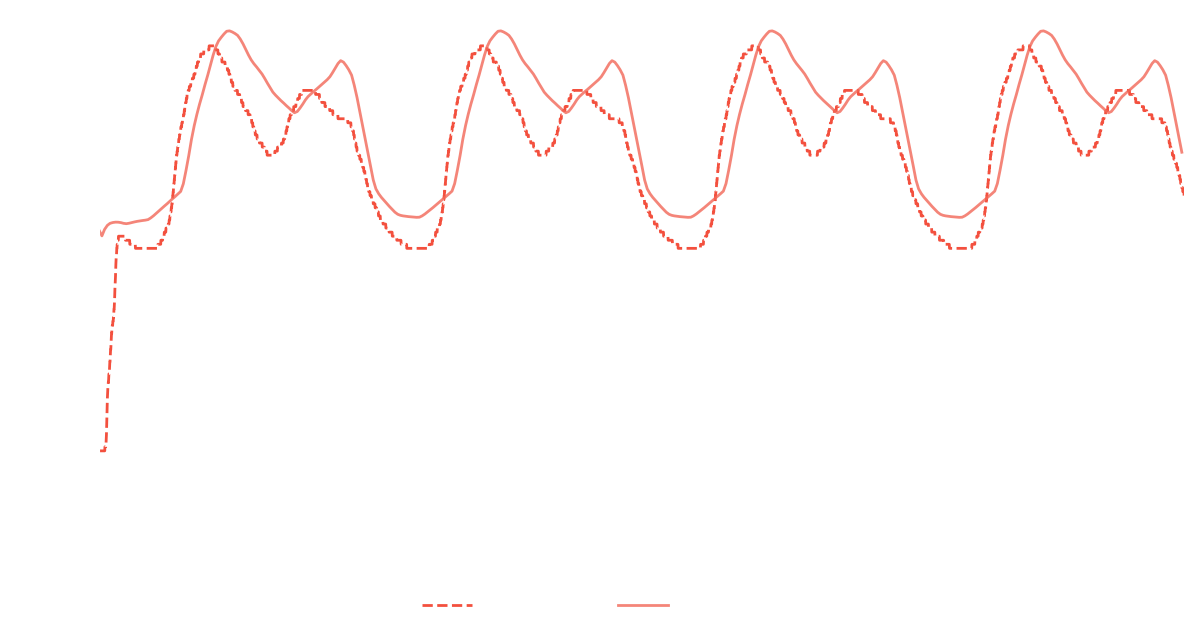

In [93]:
# All before limoliou (from st-sacrement)
STSACRA_B4_LIMOLIOU= "DOM_23807"

plotComparisonsMeasSWMMWST(None,flowModel2022Valsm3hB4Limo[[STSACRA_B4_LIMOLIOU + MOD_SUFFIX]],dfWEST_Results[["St_sacrement B4 Limoliou"]],"stsacB4Limo",[None,"#F0240E","#F26757"])

In [89]:
flowModel2022Valsm3h

,WTP (m3/h) MODEL,StSacraLimoliou (m3/h) MODEL,Pascal (m3/h) MODEL,U003_Nord_Ouest (m3/h) MODEL,UNI_602608 (m3/h) MODEL,DOM_602606 (m3/h) MODEL,UNI_602607 (m3/h) MODEL,Pompe-Beauport (m3/h) MODEL,C1 (m3/h) MODEL
LongDate,,,,,,,,,
2022-06-19 00:01:00,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0
2022-06-19 00:02:00,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0
2022-06-19 00:03:00,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0
2022-06-19 00:04:00,0.0,0.0,0.0,0.0,36.0,72.0,0.0,0.0,0.0
2022-06-19 00:05:00,0.0,0.0,0.0,0.0,108.0,72.0,36.0,0.0,36.0
...,...,...,...,...,...,...,...,...,...
2022-06-22 23:55:00,7776.0,2736.0,5040.0,504.0,252.0,180.0,432.0,180.0,2016.0
2022-06-22 23:56:00,7776.0,2736.0,5040.0,504.0,252.0,180.0,432.0,180.0,2016.0
2022-06-22 23:57:00,7740.0,2736.0,5040.0,504.0,252.0,180.0,432.0,180.0,2016.0


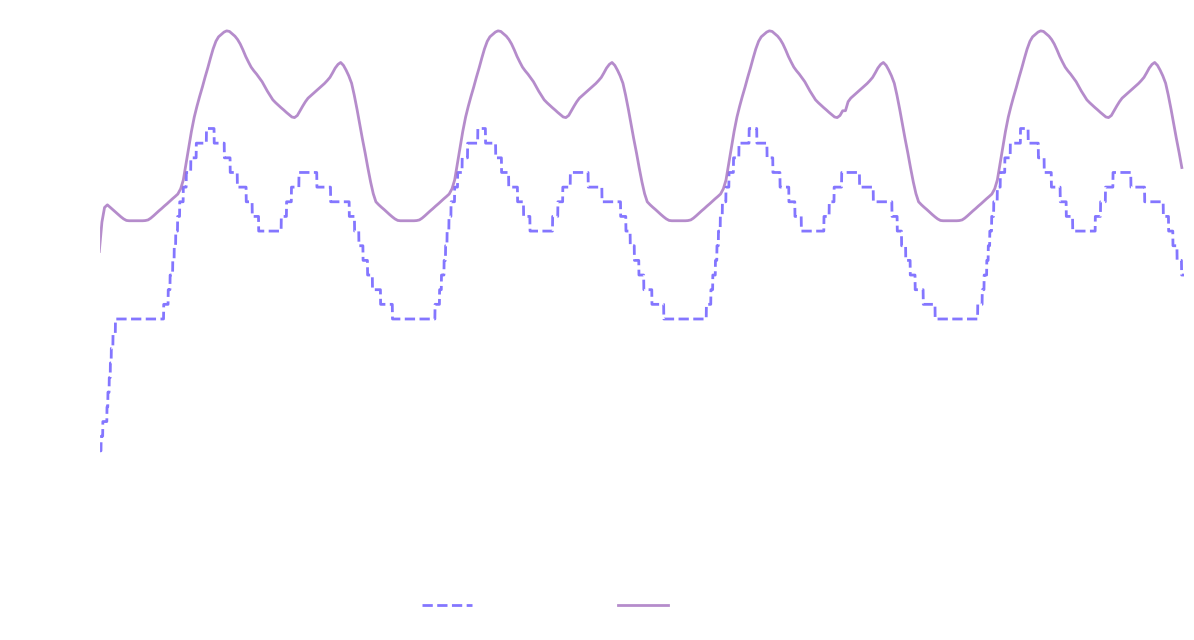

In [86]:
# Limoliou leg 

LIMOLIOULEG = "DOM_1376372"

plotComparisonsMeasSWMMWST(None,flowModel2022Valsm3hLimo[[LIMOLIOULEG + MOD_SUFFIX]],dfWEST_Results[[LIMOLIOU]],
                           "LimoliouLeg",[BEAU_C,BEAU_C2,BEAU_C3])

## Patterns!!

In [98]:
# values are in m3/s
patternComparisonCsv = '01-Data/07-DWFPatternComparison.csv'

patterns = pd.read_csv(patternComparisonCsv, delimiter = ',')
 

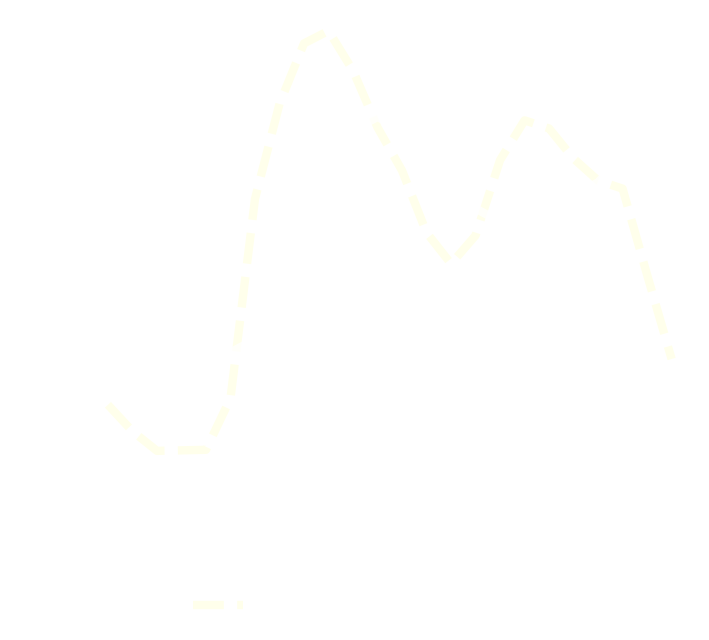

In [111]:
plotComparisonsMeasSWMMWST(None,patterns[["SWMM"]],patterns[["WEST"]],
                           "Patterns",[None,"#FFFFE6","#FFFFFF"])

In [105]:
patterns


,Time,WEST,SWMM,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,12:00 AM,0.60,0.350,NaN,NaN,NaN,NaN,NaN,NaN
1,1:00 AM,0.55,0.249,NaN,NaN,NaN,NaN,NaN,NaN
2,2:00 AM,0.50,0.174,NaN,NaN,NaN,NaN,NaN,NaN
3,3:00 AM,0.50,0.176,NaN,NaN,NaN,NaN,NaN,NaN
4,4:00 AM,0.50,0.178,NaN,NaN,NaN,NaN,NaN,NaN
5,5:00 AM,0.55,0.375,NaN,NaN,NaN,NaN,NaN,NaN
6,6:00 AM,0.60,1.137,NaN,NaN,NaN,NaN,NaN,NaN
7,7:00 AM,0.65,1.500,NaN,NaN,NaN,NaN,NaN,NaN
8,8:00 AM,1.00,1.731,NaN,NaN,NaN,NaN,NaN,NaN
9,9:00 AM,1.20,1.779,NaN,NaN,NaN,NaN,NaN,NaN
